In [12]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

## imports

import numpy as np
import xarray as xr
import GriddedData
import time

#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf

## histograms
import seaborn as sns
sns.set(color_codes=True)

from decimal import Decimal
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

%matplotlib inline

In [13]:
dir='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/'

In [14]:
dirin="/media/extra/DATA/NATL60/NATL60-I/"
gridfile=dirin+"NATL60_v4.1_cdf_mesh_hgr.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= np.squeeze(grid['nav_lat'])
navlon= np.squeeze(grid['nav_lon'])
diri='/media/extra/DATA/NATL60/NATL60-I/'
tmask='NATL60-CJM165.1d_mask_surf_filt-n80-f0.0125.nc'
mask_filt=np.squeeze(xr.open_dataset(diri+tmask)['tmask'])


/media/extra/DATA/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc


In [15]:
def plot_fine_scale_variance(fig,var,loncrs,latcrs,lon,lat,hpvarm,month):
    ''' map of the averaged fine scale variance
    '''
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    truc=np.array(hpvarm)
    truc[truc==0.]=np.nan
    cont=np.isnan(truc)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),vmin=0,vmax=1,cmap=seq_cmap,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.text(0,30,month,size=25)
    cbar.set_label('Horizontal buoyancy gradient in $10^{-7}$ $s^{-2}$',fontsize=25)
    return fig


In [16]:
def plot_hgradb_coarse(t):
    m=str(t+1).zfill(2)
    if t <9:
        year='2013'
    else:
        year='2012'
    month = {1 : 'january',
           2 : 'february',
           3 : 'march',
           4 : 'april',
           5 : 'may',
           6 : 'june',
           7 : 'july',
           8 : 'august',
           9 : 'september',
           10 : 'october',
           11 : 'november',
           12 : 'december',
    }

    tfiles='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y'+year+'m'+m+'d*.1d_hgradb.nc'
    hgradb = xr.open_mfdataset(tfiles,concat_dim='time_counter',decode_times=False)['vohgradb']
    diri='/media/extra/DATA/NATL60/NATL60-I/'
    tmask='NATL60-CJM165.1d_mask_surf_filt-n80-f0.0125.nc'
    mask_filt=np.squeeze(xr.open_dataset(diri+tmask)['tmask'])
    hgradb_mask=np.zeros(hgradb.shape)
    for tt in np.arange(hgradb_mask.shape[0]):
        truc=np.squeeze(hgradb[0,:,:].values)        
        truc[np.where(mask_filt!=1)]=np.nan
        hgradb_mask[tt,:,:]=truc[:,:]   
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hgradb_coarse=np.zeros((hgradb_mask.shape[0],3600,57,90))
    for tt in np.arange(hgradb_coarse.shape[0]):
        truc=np.squeeze(hgradb_mask[0,:,:])        
        hgradbc = crs.return_ravel(np.asarray(truc))
        hgradb_coarse[tt,:,:,:]=hgradbc 
    hgradb_coarse_stack=np.concatenate(hgradb_coarse,axis=0)
    hgradb_coarse_median=np.nanmedian(hgradb_coarse_stack,axis=0)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)

    fig = plt.figure(figsize=(20, 15))
    truc=plot_fine_scale_variance(fig,1e7*hgradb_coarse_median,loncrsm, latcrsm,navlon,navlat,hgradb[0],month[t+1])
    plt.savefig("NATL60_hgrad_median_m"+m+".png")


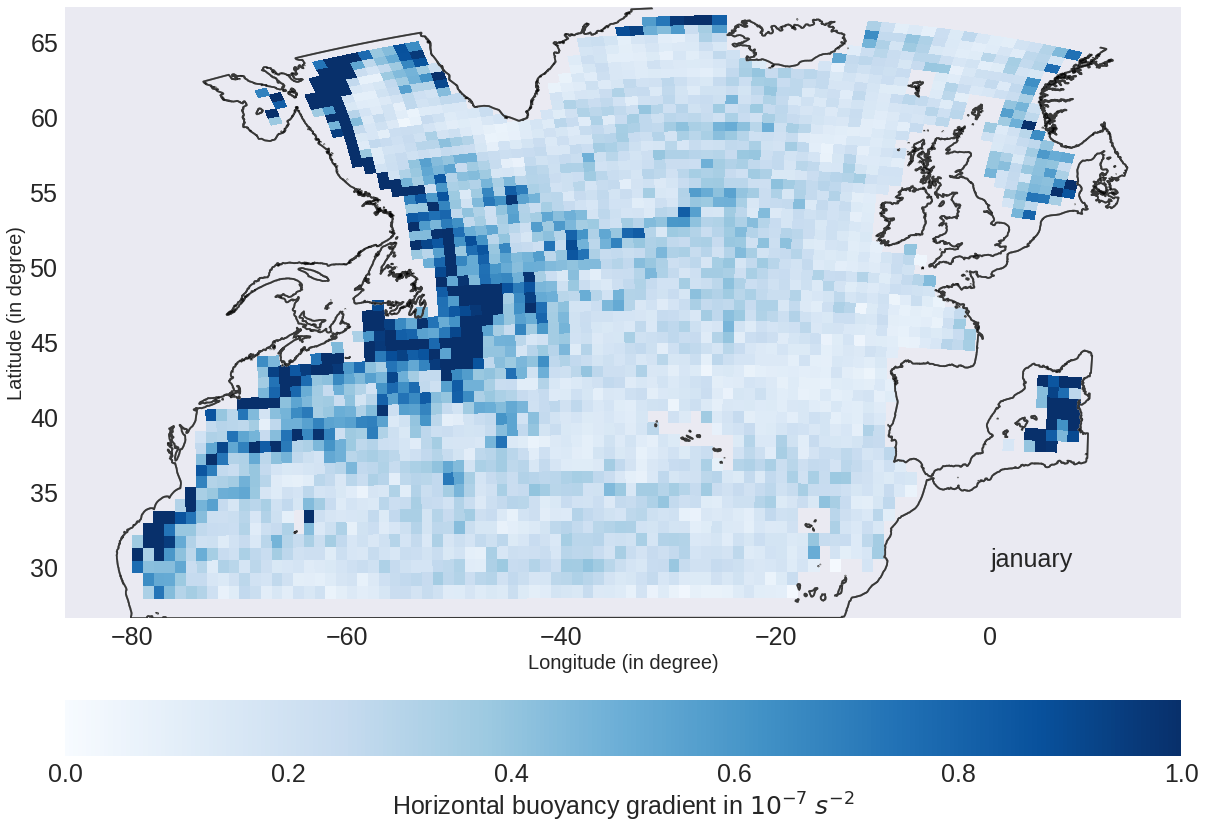

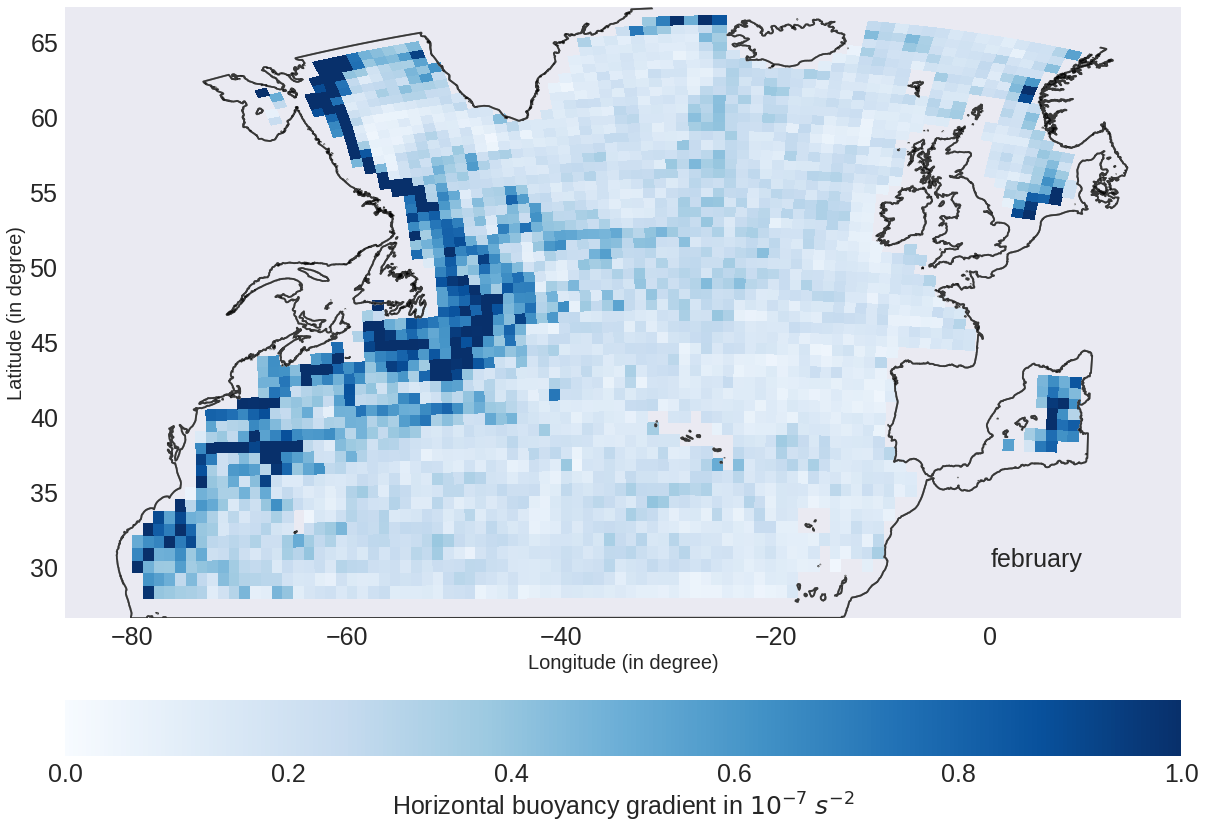

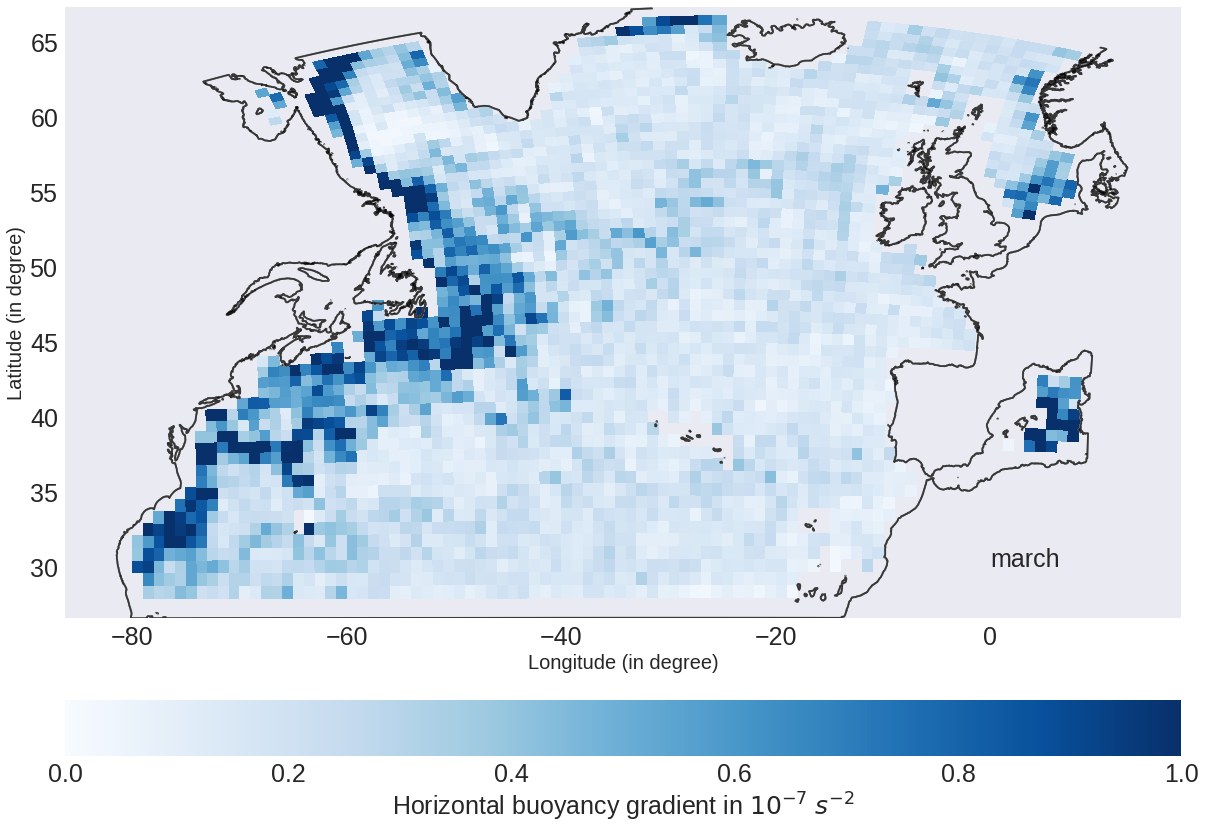

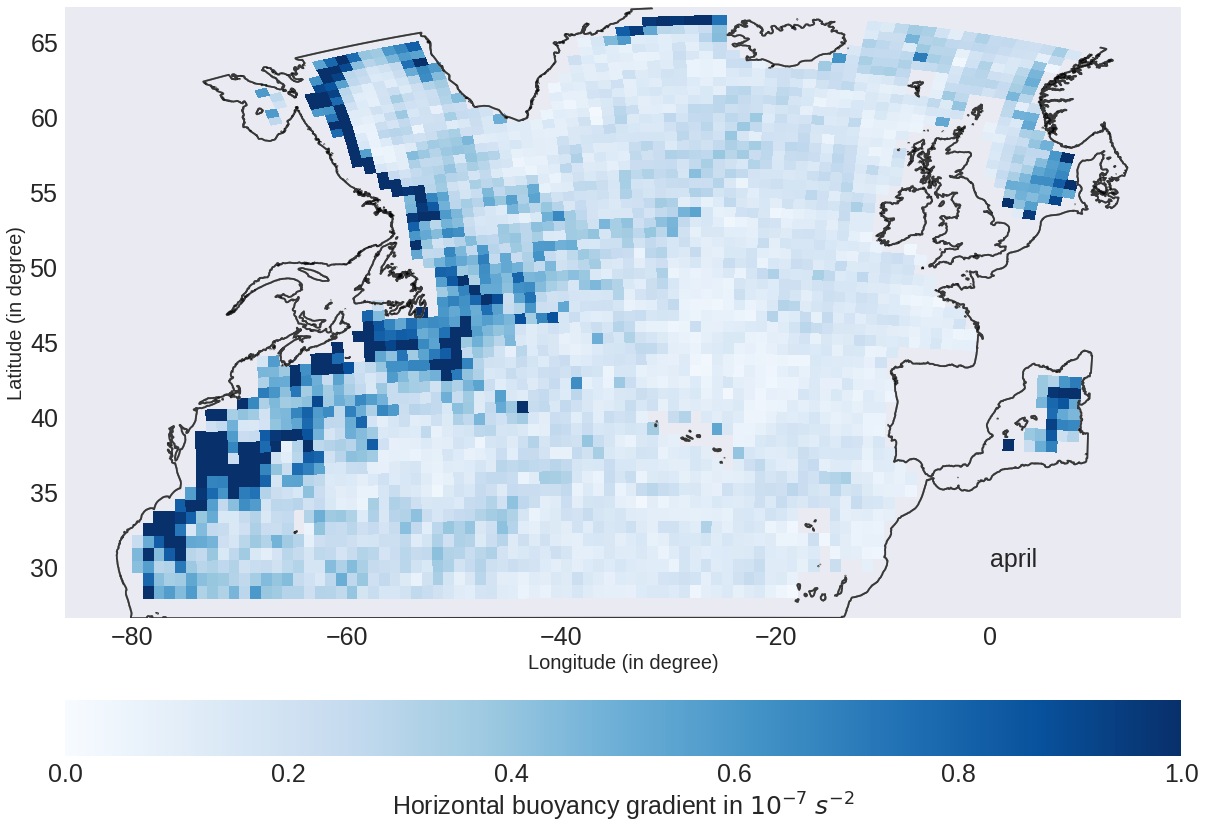

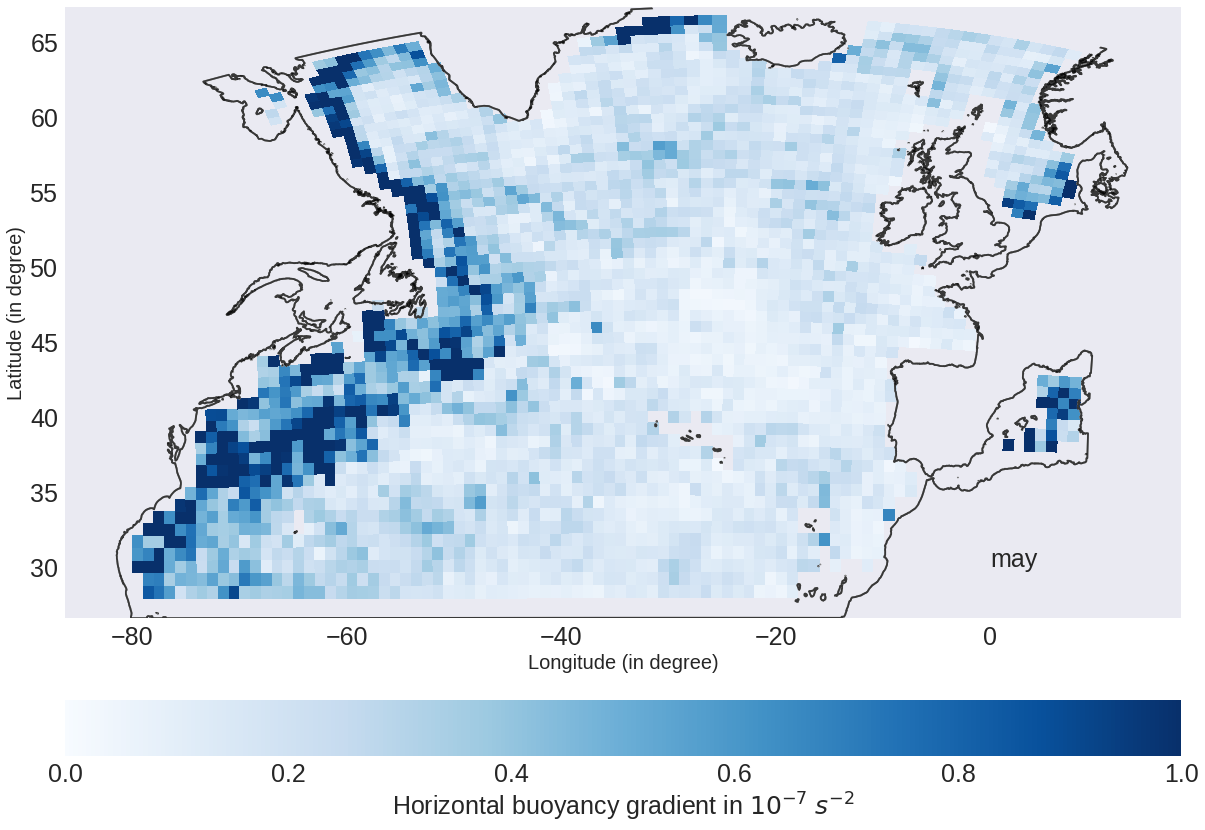

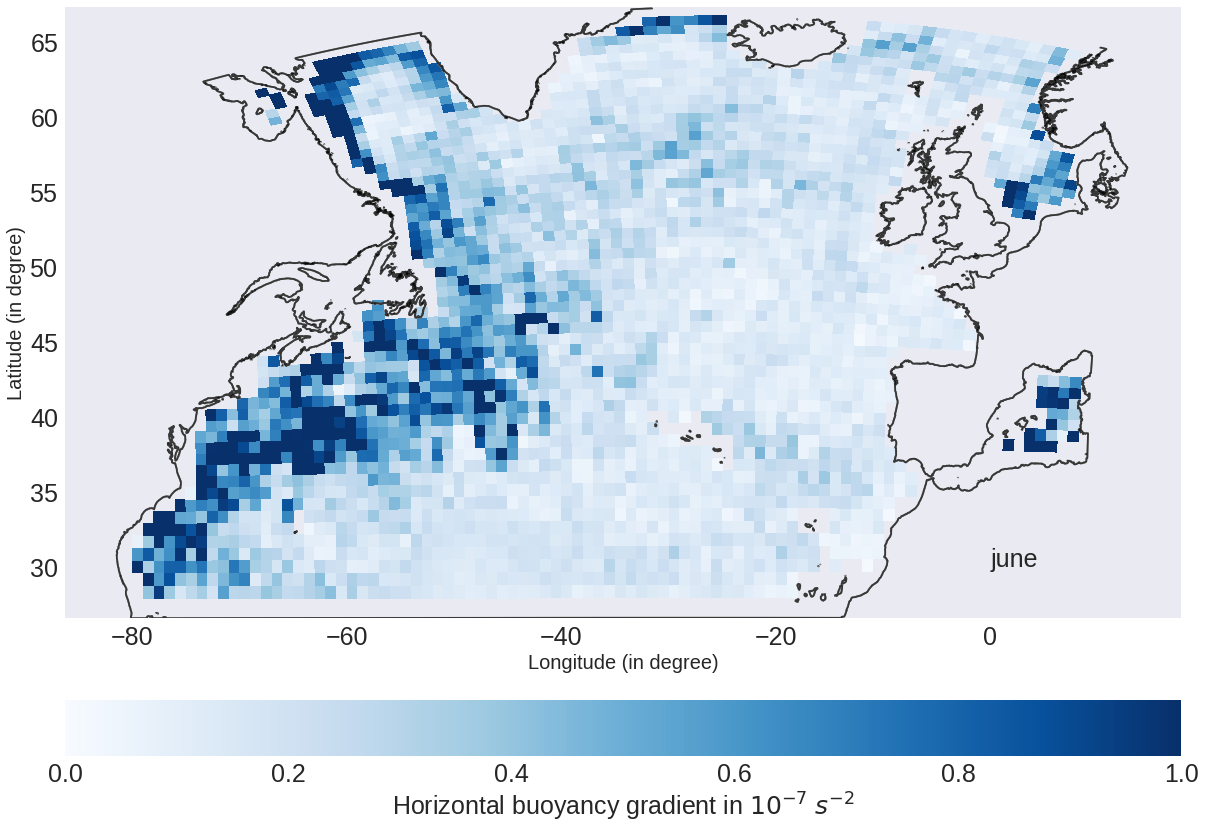

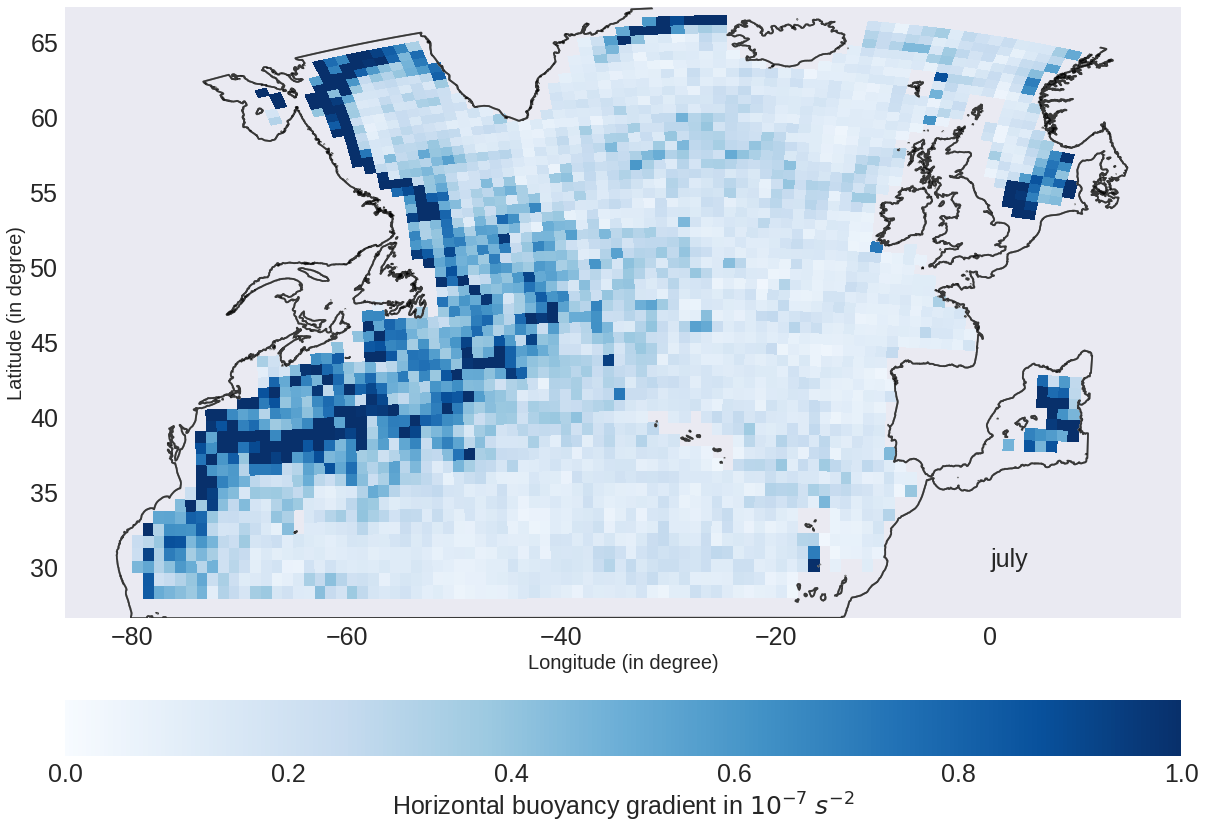

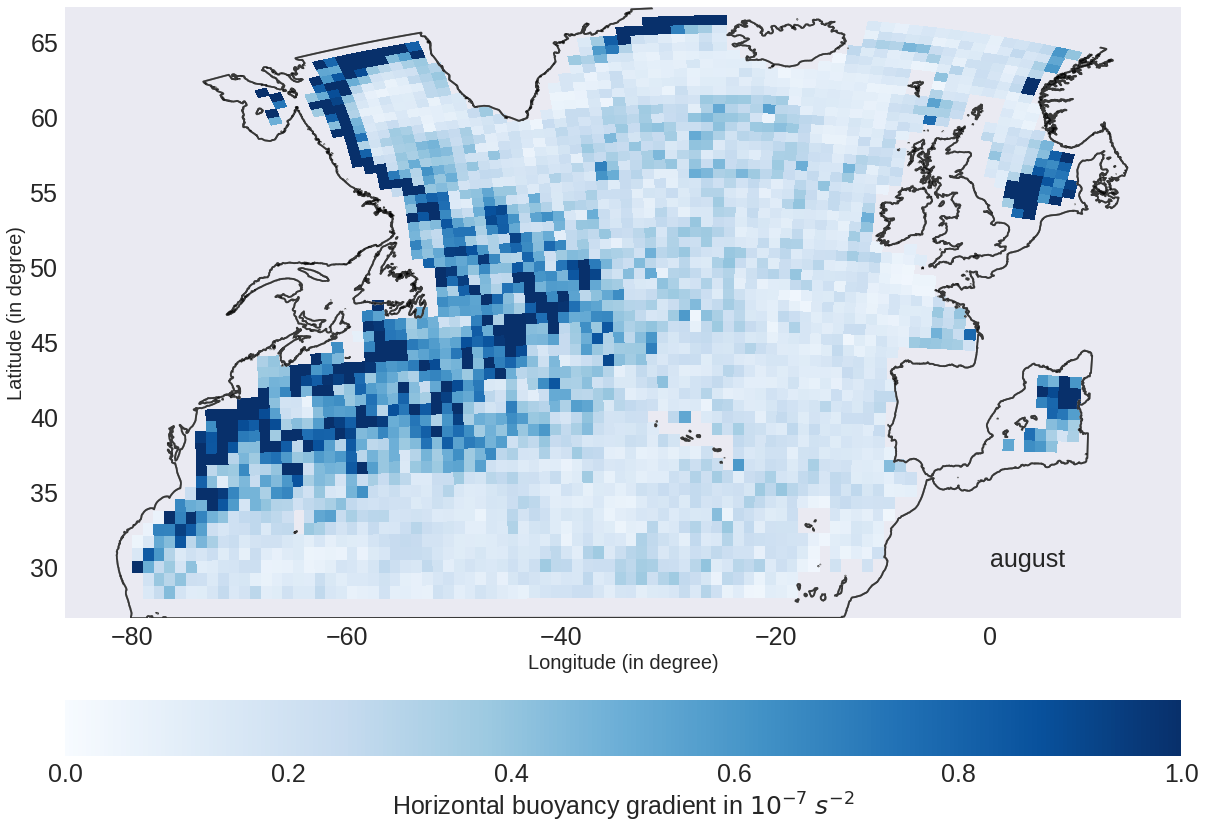

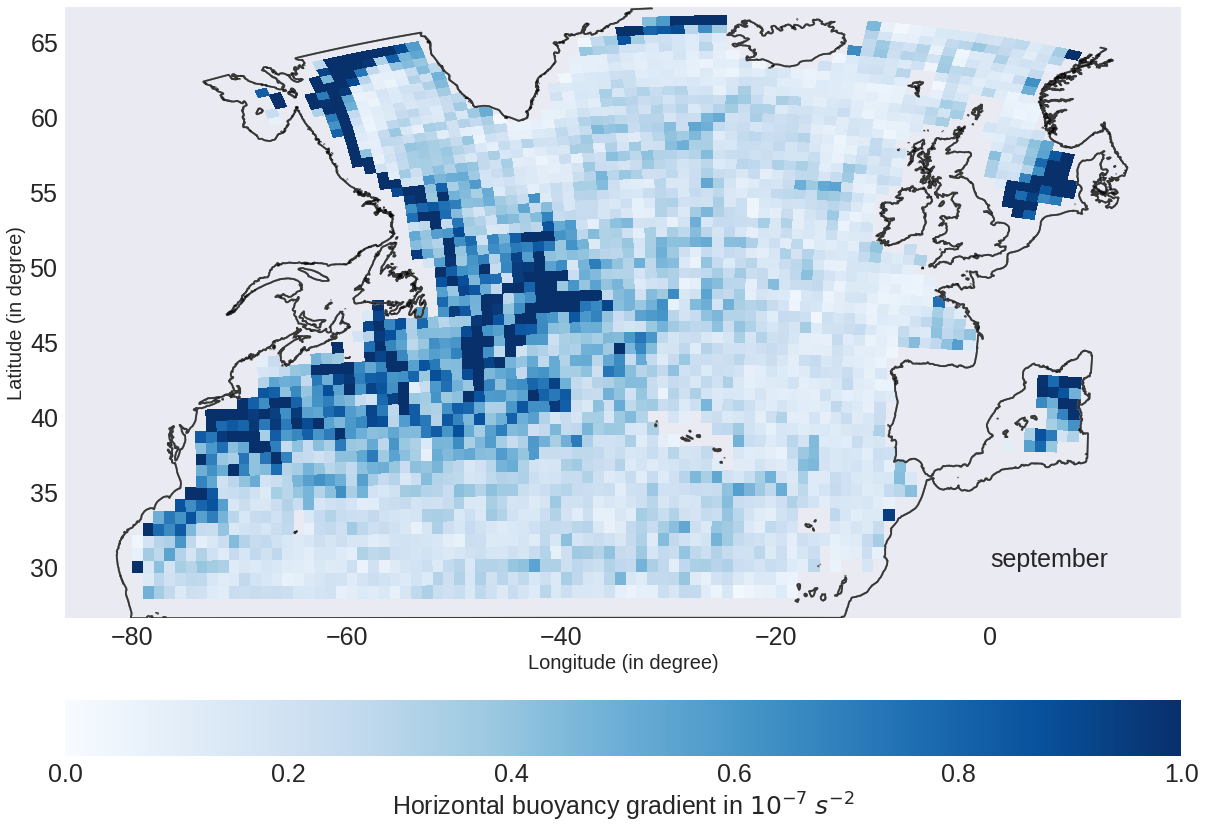

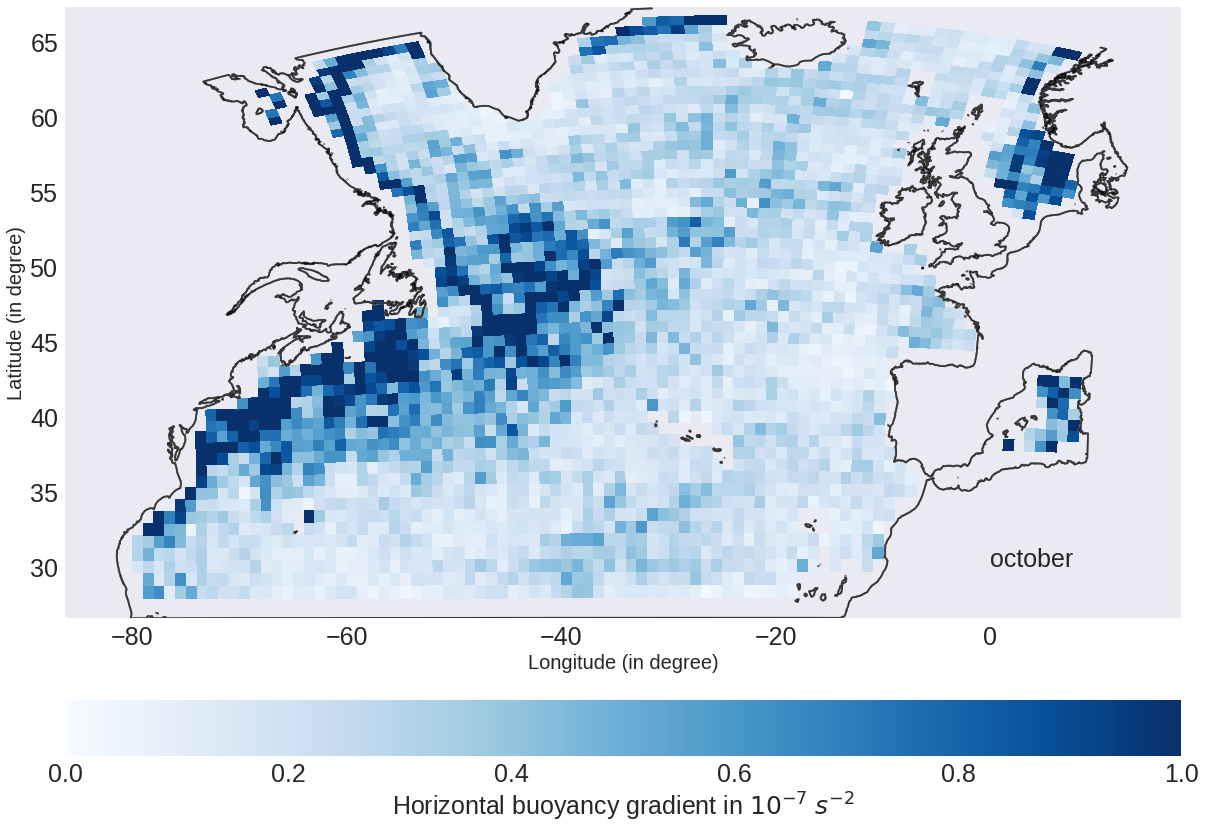

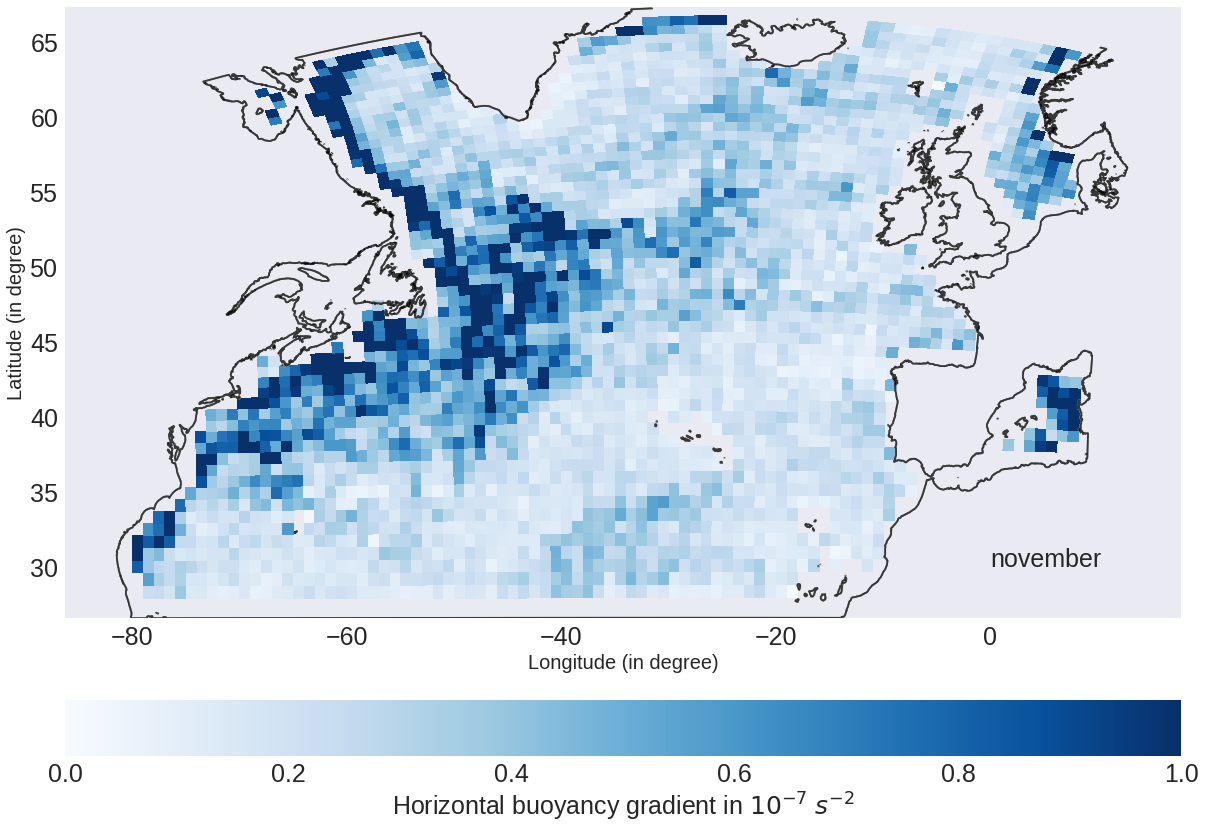

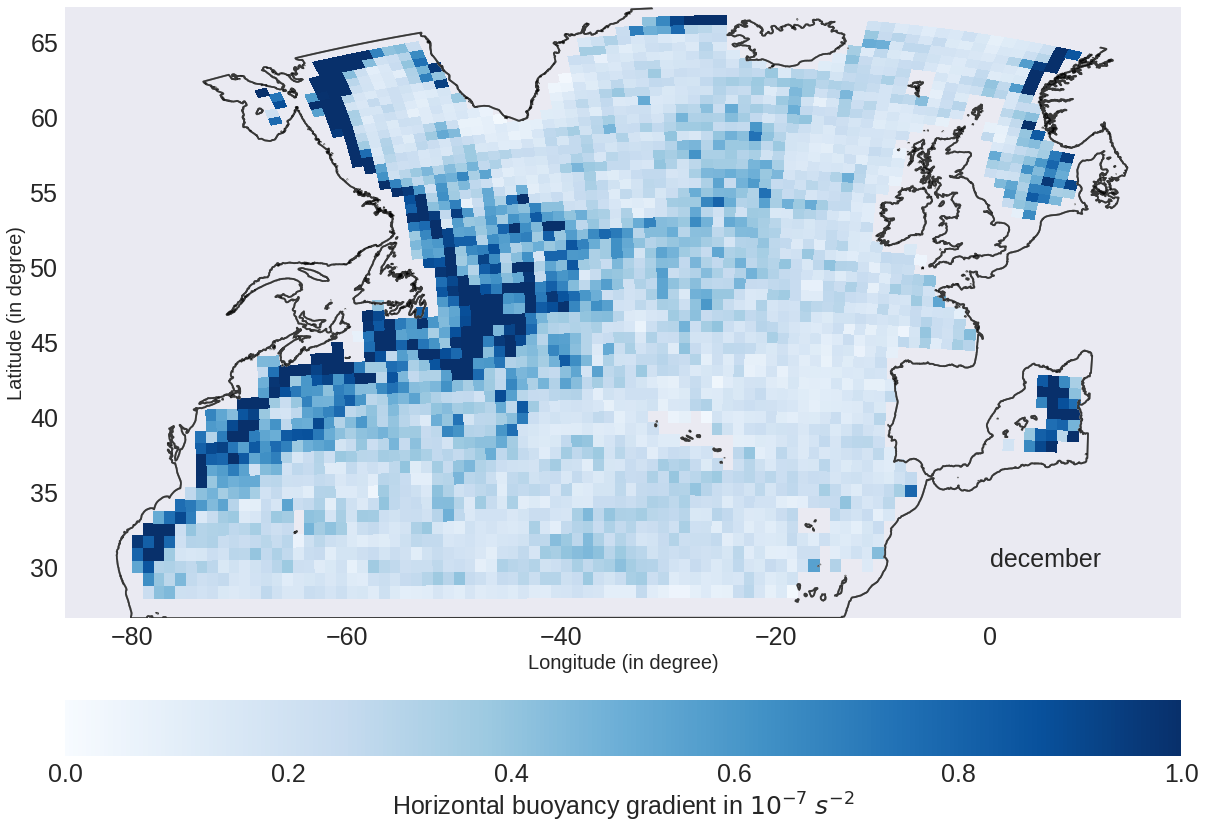

In [17]:
for k in np.arange(12):
    plot_hgradb_coarse(k)